<a href="https://colab.research.google.com/github/ayush-09/Detecting-Covid-19-Deep-Learning-/blob/master/Detecting_Covid_19_Transfer_Learning_with_Keras_and_TensorFlow_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Add, Dense, GlobalAveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler

import numpy as np
import matplotlib.pyplot as plt

## Download the dataset 

Dataset and how it was created can be read in this great Medium article: https://towardsdatascience.com/detecting-covid-19-induced-pneumonia-from-chest-x-rays-with-transfer-learning-an-implementation-311484e6afc1

In [ ]:
!gdown https://drive.google.com/uc?id=1coM7x3378f-Ou2l6Pg2wldaOI7Dntu1a
!unzip Covid_Data_GradientCrescent.zip

Downloading...
From: https://drive.google.com/uc?id=1coM7x3378f-Ou2l6Pg2wldaOI7Dntu1a
To: /content/Covid_Data_GradientCrescent.zip
154MB [00:02, 67.9MB/s]
Archive:  Covid_Data_GradientCrescent.zip
   creating: all/
   creating: all/test/
   creating: all/test/covid/
  inflating: all/test/covid/nejmoa2001191_f3-PA.jpeg  
  inflating: all/test/covid/nejmoa2001191_f4.jpeg  
  inflating: all/test/covid/nejmoa2001191_f5-PA.jpeg  
  inflating: all/test/covid/radiol.2020200490.fig3.jpeg  
  inflating: all/test/covid/ryct.2020200028.fig1a.jpeg  
  inflating: all/test/covid/ryct.2020200034.fig2.jpeg  
  inflating: all/test/covid/ryct.2020200034.fig5-day0.jpeg  
  inflating: all/test/covid/ryct.2020200034.fig5-day4.jpeg  
  inflating: all/test/covid/ryct.2020200034.fig5-day7.jpeg  
   creating: all/test/normal/
  inflating: all/test/normal/NORMAL2-IM-1385-0001.jpeg  
  inflating: all/test/normal/NORMAL2-IM-1396-0001.jpeg  
  inflating: all/test/normal/NORMAL2-IM-1400-0001.jpeg  
  inflating: all

In [ ]:
# Specify training data directory
four_class_training_dir = 'all/train'

In [ ]:
# List the folders in the directory
os.listdir(four_class_training_dir)

['pneumonia_bac', 'normal', 'covid', 'pneumonia_vir']

In [ ]:
image_generator = ImageDataGenerator(rescale = 1./255,
                                    rotation_range=50,
                                    featurewise_center = True,
                                    featurewise_std_normalization = True,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.25,
                                    zoom_range=0.1,
                                    zca_whitening = True,
                                    channel_shift_range = 20,
                                    horizontal_flip = True ,
                                    vertical_flip = True ,
                                    validation_split = 0.1)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:342: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


In [ ]:
train_generator = image_generator.flow_from_directory(batch_size = 35, 
                                                      directory=four_class_training_dir, 
                                                      shuffle= True, 
                                                      target_size=(224,224), 
                                                      class_mode = 'categorical', 
                                                      subset="training")

Found 243 images belonging to 4 classes.


In [ ]:
validation_generator = image_generator.flow_from_directory(batch_size = 35, 
                                                           directory= four_class_training_dir, 
                                                           shuffle= True, target_size=(256,256),
                                                           class_mode = 'categorical', 
                                                           subset="validation")

Found 27 images belonging to 4 classes.


In [ ]:
class_names_mapper = {0 : 'Covid-19', 1 : 'Normal' , 2: 'Bacterial Pneumonia', 3 : 'Pneumonia Viral'}

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


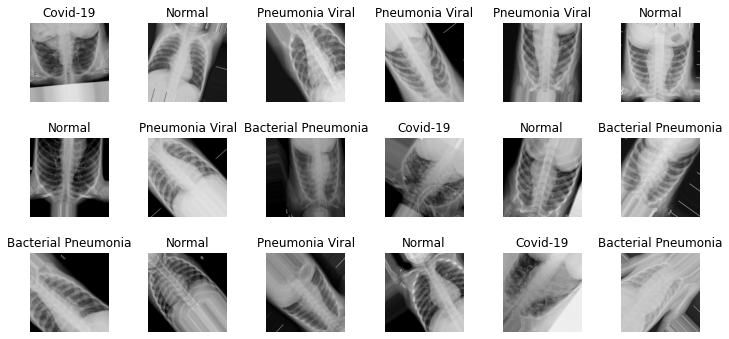

In [ ]:
images, labels = next(train_generator)
L = 3
W = 6

fig, axes = plt.subplots(L, W, figsize = (12, 6))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(images[i])
    axes[i].set_title(class_names_mapper[np.argmax(labels[i])])
    axes[i].axis('off')

plt.subplots_adjust(wspace = 0.5)    

In [ ]:
mobile_net = MobileNetV2(weights='imagenet', 
                         include_top = False, 
                         input_shape=(224, 224, 3))

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
mobile_net.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [ ]:
# Lets freeze the whole base model (in our case MobileNet v1)
mobile_net.trainable = False

In [ ]:
head_network = mobile_net.output
head_network = GlobalAveragePooling2D()(head_network)
head_network = Dense(256, activation = "relu")(head_network)
head_network = Dropout(0.6)(head_network)
head_network = Dense(4, activation = 'softmax')(head_network)

model = Model(inputs = mobile_net.input, outputs = head_network)

In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

In [ ]:
model.compile(loss = 'categorical_crossentropy', 
              optimizer=optimizers.Adam(lr = 0.0001, decay = 1e-6), 
              metrics= ["accuracy"])

In [ ]:
# Use early stopping as a safety net so our net is not overfitted
early_stopping_callback_obj = EarlyStopping(monitor='val_loss', 
                                            verbose=1, 
                                            patience=2)

# Create Checkpointer that saves the model based on the validation loss
model_saver = ModelCheckpoint(filepath="covid19net.hdf5", verbose=1, save_best_only=True)

In [ ]:
history = model.fit_generator(train_generator, 
                            epochs = 10,
                            steps_per_epoch= len(train_generator),
                            validation_data=validation_generator,
                            validation_steps= len(validation_generator),
                            callbacks=[model_saver, early_stopping_callback_obj],
                            verbose=1)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/10
7/7 [==============================] - ETA: 0s - loss: 1.0928 - accuracy: 0.5103
Epoch 00001: val_loss improved from inf to 0.79690, saving model to covid19net.hdf5
7/7 [==============================] - 9s 1s/step - loss: 1.0928 - accuracy: 0.5103 - val_loss: 0.7969 - val_accuracy: 0.7037
Epoch 2/10
7/7 [==============================] - ETA: 0s - loss: 1.0167 - accuracy: 0.5391
Epoch 00002: val_loss improved from 0.79690 to 0.75894, saving model to covid19net.hdf5
7/7 [==============================] - 8s 1s/step - loss: 1.0167 - accuracy: 0.5391 - val_loss: 0.7589 - val_accuracy: 0.7778
Epoch 3/10
7/7 [==============================] - ETA: 0s - loss: 0.9423 - accuracy: 0.6091
Epoch 00003: val_loss did not improve from 0.75894
7/7 [==============================] - 7s 1s/step - loss: 0.9423 - accuracy: 0.6091 - val_loss: 0.8726 - val_accuracy: 0.6296
Epoch 4/10
7/7 [==============================] - ETA: 0s - loss: 0.9435 - accuracy: 0.6049
Epoch 00004: val_loss did not i

In [ ]:
def plot_performance(history=None, figure_directory=None):
    xlabel = 'Epoch'
    legends = ['Training', 'Validation']

    ylim_pad = [0.005, 0.005]
#     ylim_pad = [0, 0]


    plt.figure(figsize=(20, 5))

    # Plot training & validation Accuracy values

    y1 = history.history['accuracy']
    y2 = history.history['val_accuracy']

    min_y = min(min(y1), min(y2))-ylim_pad[0]
    max_y = max(max(y1), max(y2))+ylim_pad[0]


    plt.subplot(121)

    plt.plot(y1)
    plt.plot(y2)

    plt.title('Model Accuracy\n', fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Accuracy', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()


    # Plot training & validation loss values

    y1 = history.history['loss']
    y2 = history.history['val_loss']

    min_y = min(min(y1), min(y2))-ylim_pad[1]
    max_y = max(max(y1), max(y2))+ylim_pad[1]


    plt.subplot(122)

    plt.plot(y1)
    plt.plot(y2)

    plt.title('Model Loss\n', fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Loss', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()
    if figure_directory:
        plt.savefig(figure_directory+"/history")

    plt.show()

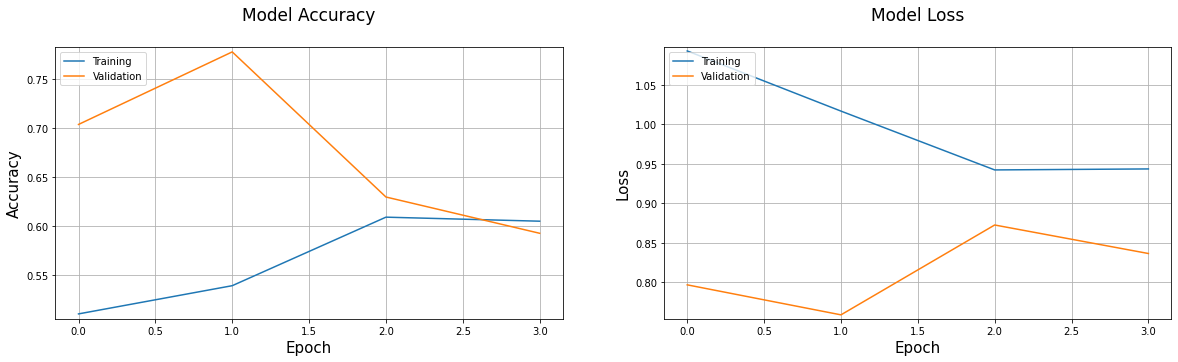

In [ ]:
plot_performance(history=history)

In [ ]:
test_directory = 'all/test'

In [ ]:
test_img_generator = ImageDataGenerator(rescale = 1./255)

test_generator = test_img_generator.flow_from_directory(batch_size = 35, 
                                              directory= test_directory, 
                                              shuffle= True,
                                              target_size=(224,224), 
                                              class_mode= 'categorical')

evaluate = model.evaluate_generator(test_generator, 
                                    steps= len(test_generator),
                                    verbose =1)

print('Accuracy Test : {}'.format(evaluate[1]))

Found 36 images belonging to 4 classes.
2/2 [==============================] - 0s 9ms/step - loss: 0.9253 - accuracy: 0.6667
Accuracy Test : 0.6666666865348816


In [ ]:
from keras.models import load_model
model_name='Covid Detector.h5'
model.save(model_name)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
